# Autoregressive Gaussian models

A simple example for how to use autoregressive Gaussian ratio estimators to fit and sample from an exponential Gaussian process with heteroscedastic noise.

In [158]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
import numpy as np
import torch
from torch import nn

import swyft
from swyft.utils.ns import SwyftSimpleSliceSampler
from swyft.lightning.estimators import LogRatioEstimator_Autoregressive, LogRatioEstimator_Gaussian, LogRatioEstimator_Autoregressive_Gaussian

import pylab as plt

#import pytorch_lightning as pl

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

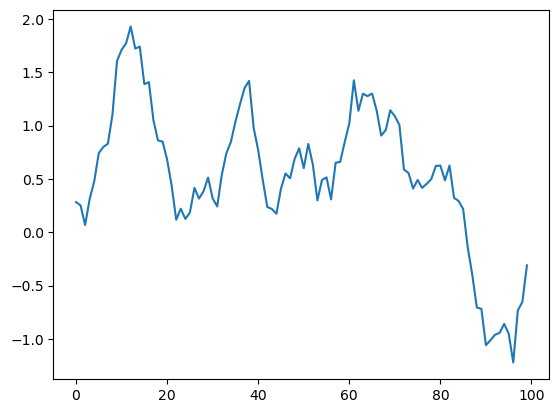

In [160]:
N = 100

l = torch.arange(N)
L1, L2 = torch.meshgrid(l, l)
T = torch.abs(L1 - L2)
Cov = torch.exp(-T**2/30)*0.2 + torch.exp(-T**2/200)*.2 + torch.exp(-T**2/0.001)*.01

def sample_GP(N, gamma = 3):
    z = np.random.multivariate_normal(np.zeros(N), Cov.numpy())
    return z

z = sample_GP(N, gamma = 2.5)
plt.plot(z)

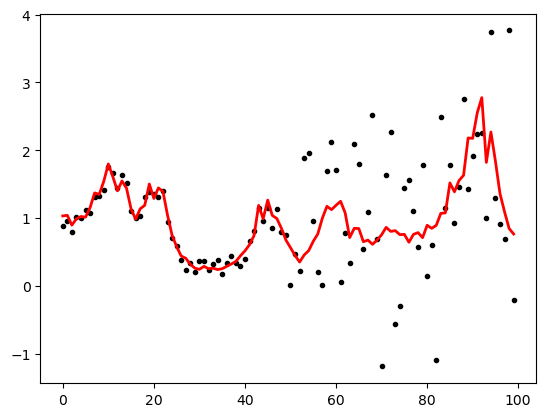

In [161]:
D = 100

class Sim(swyft.Simulator):
    def __init__(self, sigma = .1):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.sigma = np.ones(D)*sigma
        self.sigma[50:] *= 10
  
    def build(self, graph):
        z = graph.node("z", lambda: sample_GP(D, gamma = 2.5))
        y = graph.node("y", lambda z: np.exp(z), z)
        x = graph.node("x", lambda y: y + np.random.randn(D)*self.sigma, y)
        
sim = Sim()
for _ in range(1):
    s = sim.sample()
    plt.plot(s['x'], 'k.')
    plt.plot(s['y'], 'r', lw=2)

In [162]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3, D = 100):
        super().__init__()

        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-3, lrs_factor=0.1, lrs_patience=3)
        self.num_params = D
        self.lre = LogRatioEstimator_Autoregressive_Gaussian(D, "mu", minstd = 1e-10)
        self.l = nn.Sequential(
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(1)
        )

    def forward(self, A, B):
        x = A["x"]
        f = self.l(x.unsqueeze(-1)).squeeze(-1)
        result = self.lre(f, A['z'], B['z'])
        return result

In [172]:
sim = Sim()
samples = sim.sample(10000)
dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 64)

  0%|          | 0/10000 [00:00<?, ?it/s]

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [173]:
net = Network(D=D)

In [174]:
net.lre._momentum = 0.01

In [178]:
trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = 1, max_epochs = 10)
trainer.fit(net, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                      | Params
-------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Autoregressive_Gaussian | 20.0 K
1 | l    | Sequential                                | 16.9 K
-------------------------------------------------------------------
26.9 K    Trainable params
10.0 K    Non-trainable params
36.9 K    Total params
0.148     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


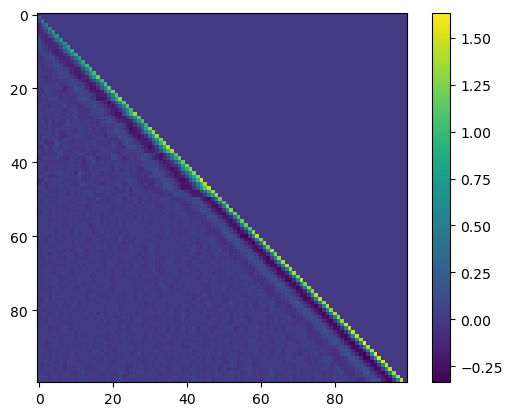

In [179]:
L = net.lre.L.detach().cpu().numpy()
plt.imshow(L)
plt.colorbar()

4198
tensor(-1.9168, device='cuda:0', dtype=torch.float64)


/tmp/ipykernel_3384106/3061711656.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f = net.l(torch.tensor(x).cuda().unsqueeze(-1)).squeeze(-1).detach()


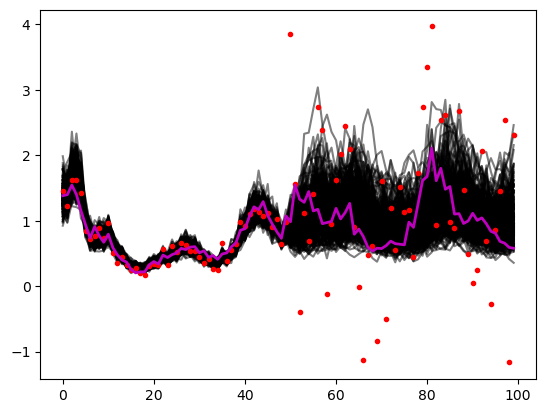

In [180]:
Cov = Cov.double().cuda()
i = np.random.randint(len(samples))
print(i)
x = torch.tensor(samples[i]['x'])
y = torch.tensor(samples[i]['y'])
net.cuda()
f = net.l(torch.tensor(x).cuda().unsqueeze(-1)).squeeze(-1).detach()
n = 300
draws = net.lre.get_post_samples(n, f, prior_cov = Cov, gamma = 1).cpu()

for i in range(n):
    plt.plot(np.exp(draws[i]), 'k', alpha = 0.5)

plt.plot(x, 'r.')
plt.plot(y, 'm', lw = 2)